## DBSCAN 

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN

## About data

Источник данных: https://archive.ics.uci.edu/ml/datasets/Wholesale+customers

Набор данных Wholesale customers относится к клиентам оптового дистрибьютора. Он включает годовые расходы в денежных единицах на различные категории товаров.

    1) FRESH: расходы за год на свежие продукты (непрерывная переменная);
    2) MILK: расходы за год на молочные продукты (непрерывная переменная);
    3) GROCERY: расходы за год на продовольственные товары / бакалею (непрерывная переменная);
    4) FROZEN: расходы за год на замороженные продукты (непрерывная переменная);
    5) DETERGENTS_PAPER: расходы за год на моющие средства и бумажные изделия (непрерывная переменная);
    6) DELICATESSEN: расходы за год на деликатесы (непрерывная переменная);
    7) CHANNEL: канал клиента - 1. индустрия общественного питания Horeca (отели/рестораны/кафе) или 2. розничный канал Retail (категориальная переменная);
    8) REGION: регион клиента - Lisnon (1), Oporto (2) или Other (3) (Категориальная переменная);  

Цель исследования — определить оптимальное разбиение выборки на кластеры, выявить наблюдения, рассматриваемые как выбросы, и установить признаки, обусловливающие их выделение.

In [56]:
df = pd.read_csv('D:/Machine Learning/Новая папка/_DATA/wholesome_customers_data.csv')

In [57]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


## Exploratory Data Analysis

Набор данных представлен числовыми признаками.

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


Пропуски в данных отсутствуют.

In [59]:
df.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

Статистические метрики для числовых колонок.

In [60]:
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


**Взаимосвязь между годовыми расходами на молочные продукты (Milk) и продукты питания (Grocery) в зависимости от канала сбыта**

- Общие тенденции  
Наблюдается положительная корреляция между расходами на молоко и продукты питания: клиенты, которые тратят больше на молоко, как правило, выделяют больше средств и на продукты питания.  

  
1. Канал Horeca (отели/рестораны/кафе) (1):  
Траты более сгруппированы, без экстремально больших значений.  
Основная масса клиентов сосредоточена в диапазоне до 10 000 – 15 000 по обоим признакам.  

  
2. Канал Retail (розница) (2):  
В среднем тратит больше, чем Horeca.  
Среди них заметны клиенты с экстремально высокими значениями (outliers) — до 70 000 по молочным и 90 000 по бакалее.
Больше разброс значений, чем у Horeca.  

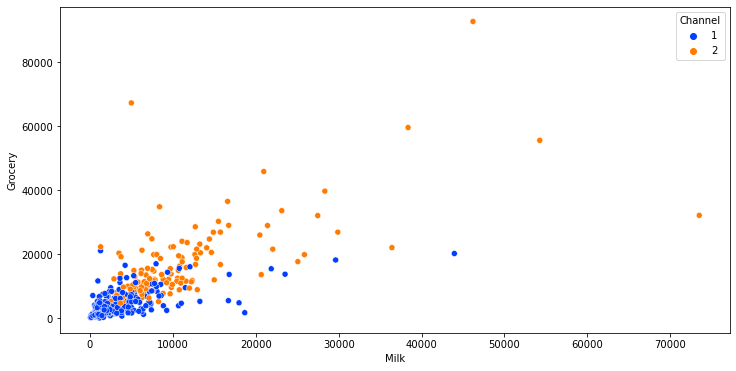

In [62]:
plt.figure(figsize=(12,6))
sns.scatterplot(y=df['Grocery'], x=df['Milk'], hue=df['Channel'], palette='bright');

**Распределение расходов за год на молочные продукты (Milk) в зависимости от канала сбыта**

- Распределение сильно смещено вправо (right-skewed):   
у большинства клиентов расходы на молочные продукты находятся в диапазоне до 10 000, но встречаются и редкие высокие значения (до 70 000).  
  

- Канал Horeca (отели/рестораны/кафе) (1)  
Более предсказуемое, сконцентрированное поведение, расходы преимущественно в нижнем диапазоне.
Большинство значений находится в нижнем диапазоне расходов (от 0 до 10 000).
Пик наблюдается в районе 1 000 – 3 000, что отражает более стабильные и умеренные закупки.  
При больших объёмах (свыше 15 000) Horeca практически отсутствует.  

  
- Канал Retail (2)  
Высокая дисперсия, наличие клиентов с очень большими закупками.  
Представлен более равномерно, особенно в средних и высоких значениях расходов (от 10 000 и выше).
Есть значительное количество клиентов с расходами 20 000–70 000, чего почти нет у Horeca.
Это может говорить о наличии крупных розничных покупателей (например, сети магазинов или дистрибьюторы), которые обеспечивают основную часть высоких значений.

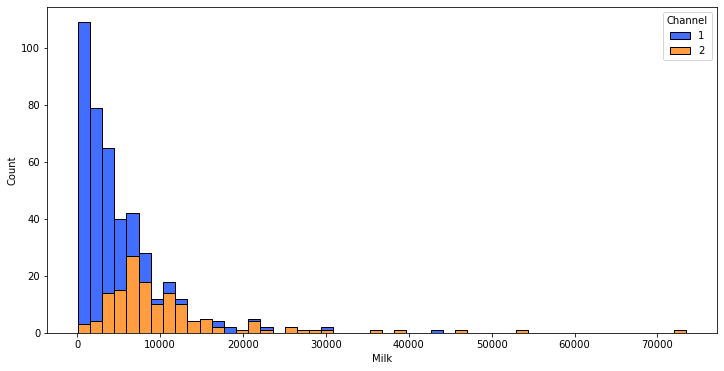

In [63]:
plt.figure(figsize=(12,6))
sns.histplot(df,x='Milk',hue='Channel',multiple="stack", palette='bright');

**Корреляционный анализ**

**Кластерная карта для корреляции между отдельными товарными категориями.**  

1. Сильные корреляции  
- Очень высокая корреляция: Grocery ↔ Detergents_Paper (0.92)  
Интерпретация: клиенты, которые много тратят на бакалею, почти всегда тратят и на моющие средства. Это логично, так как оба сегмента связаны с домашним хозяйством и розницей.  

- Высокая корреляция: Milk ↔ Grocery (0.73) и Milk ↔ Detergents_Paper (0.66)  
Интерпретация: молочные продукты покупают вместе с бакалеей и бытовыми товарами. Это снова указывает на розничный канал.  

2. Средние корреляции  
- Слабая, но положительная связь: Delicatessen ↔ Frozen (0.39) и Delicatessen ↔ Fresh (0.24)  
Интерпретация: клиенты, закупающие деликатесы, могут также брать замороженные и свежие продукты. Вероятно, это больше про Horeca.  

3. Низкие или отрицательные корреляции  
- Практически отсутствует взаимосвязь: Fresh ↔ Grocery (-0.012), Frozen ↔ Grocery (-0.04), Detergents_Paper ↔ Fresh (-0.1)   
Интерпретация: покупки свежих и замороженных продуктов не зависят от объёмов бакалеи и бытовой химии.   

Это может быть признаком разделения по каналам: 
- Grocery, Detergents_Paper, Milk — типичный набор для розничных покупателей (Retail): домашние покупки, товары длительного хранения и бытовая химия.

- Fresh, Frozen, Delicatessen — типичный набор для Horeca (рестораны, кафе, гостиницы): свежие продукты, полуфабрикаты, деликатесы для приготовления блюд.

Таким образом, Horeca ориентирован на Fresh/Frozen, а Retail – на Grocery/Detergents.  

Кластеризация:  
- Кластер 1 (Retail): Grocery, Detergents_Paper, Milk  
- Кластер 2 (Horeca): Fresh, Frozen, Delicatessen  

Correlation Between Spending Categories


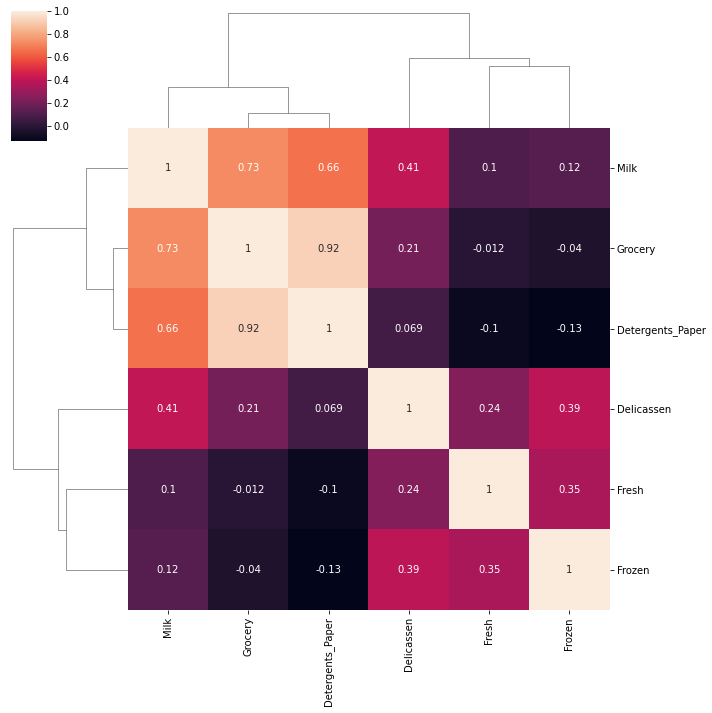

In [64]:
print('Correlation Between Spending Categories')
sns.clustermap(df.drop(['Region','Channel'],axis=1).corr(),annot=True);

**Парная взаимосвязь между переменными в зависимости от региона.**

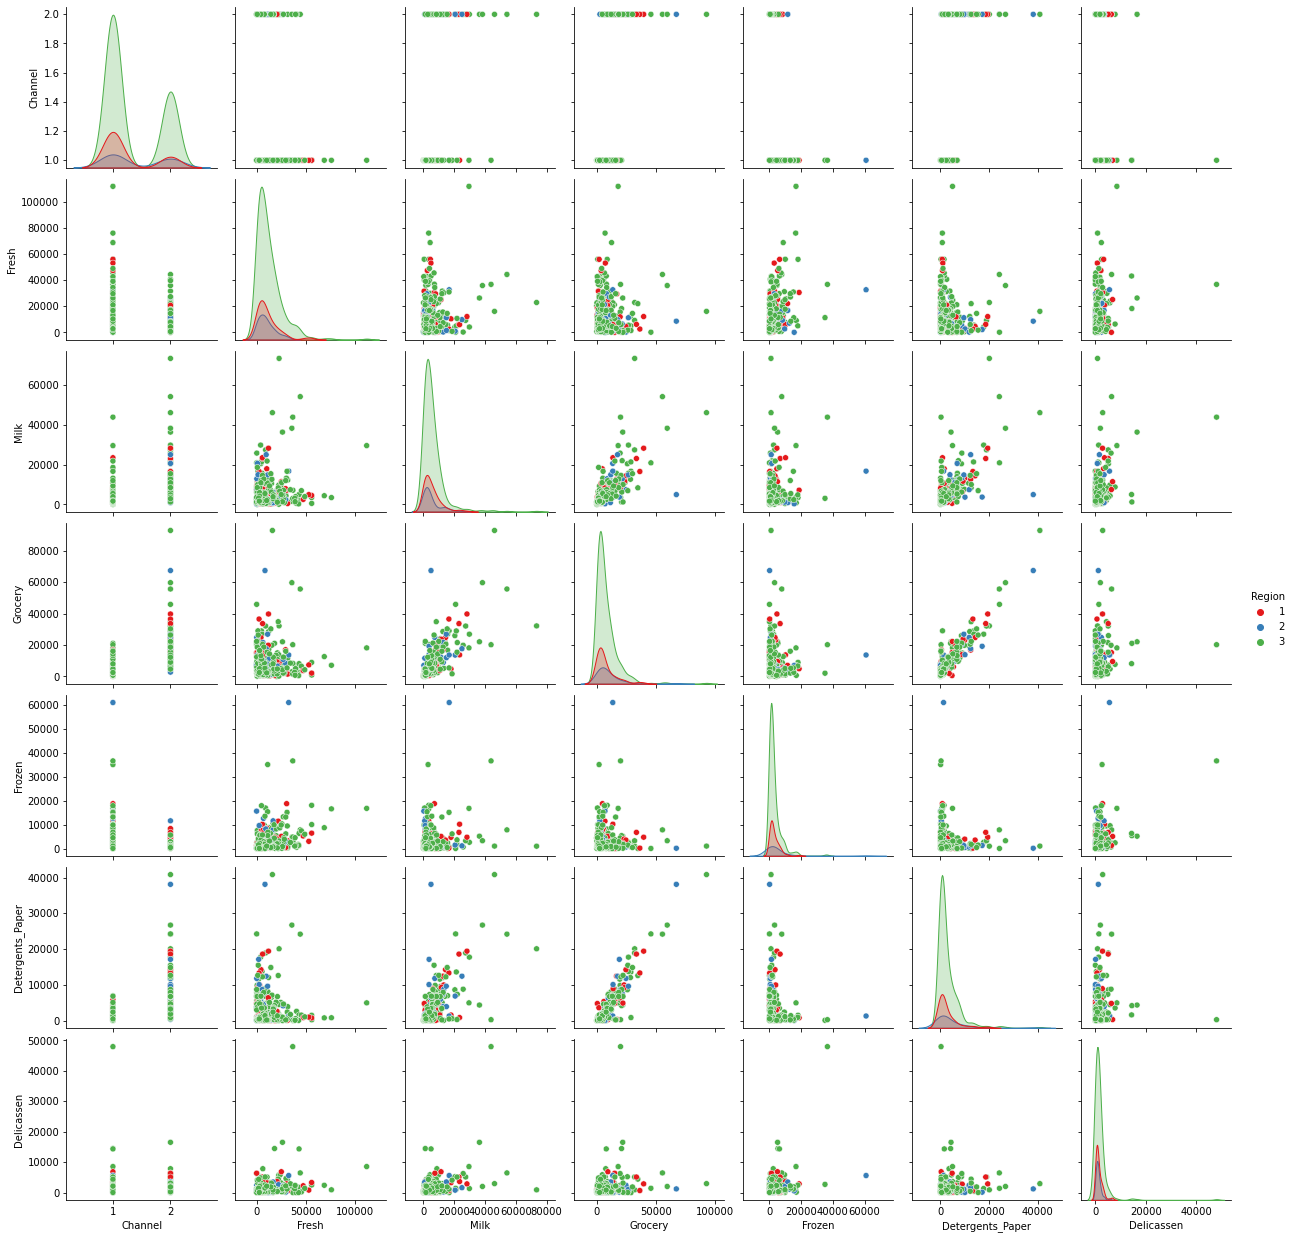

In [65]:
sns.pairplot(df,hue='Region',palette='Set1');

**Парная взаимосвязь между переменными в зависимости от канала.**

На многих графиках каналы явно различимы.

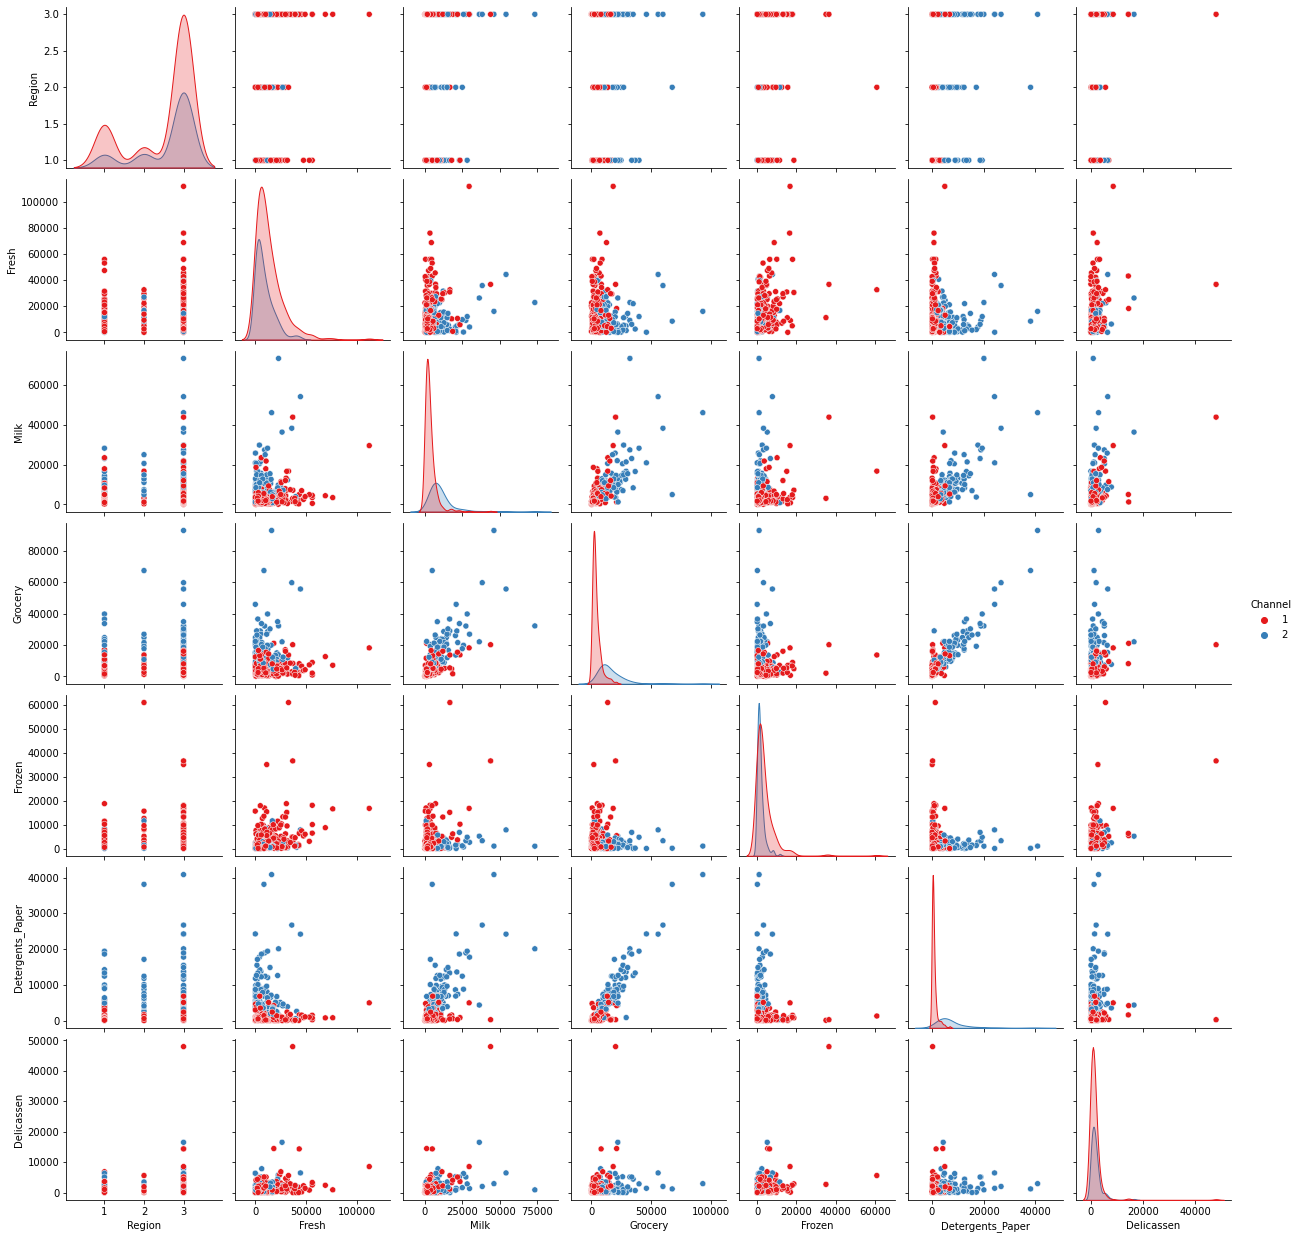

In [66]:
sns.pairplot(df,hue='Channel',palette='Set1');

 ## DBSCAN Clustering

Масштабирование признаков.

In [67]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(df)
scaled_X

array([[ 1.44865163,  0.59066829,  0.05293319, ..., -0.58936716,
        -0.04356873, -0.06633906],
       [ 1.44865163,  0.59066829, -0.39130197, ..., -0.27013618,
         0.08640684,  0.08915105],
       [ 1.44865163,  0.59066829, -0.44702926, ..., -0.13753572,
         0.13323164,  2.24329255],
       ...,
       [ 1.44865163,  0.59066829,  0.20032554, ..., -0.54337975,
         2.51121768,  0.12145607],
       [-0.69029709,  0.59066829, -0.13538389, ..., -0.41944059,
        -0.56977032,  0.21304614],
       [-0.69029709,  0.59066829, -0.72930698, ..., -0.62009417,
        -0.50488752, -0.52286938]])

Оценка оптимального значения для параметра epsilon.  

- диапазон значений для проверки: np.linspace(0.001,3,50)

In [68]:
outlier_percent = []

for eps in np.linspace(0.001,3,50):
    
    dbscan = DBSCAN(eps=eps, min_samples=2*scaled_X.shape[1])
    dbscan.fit(scaled_X)
    
    perc_outliers = 100 * np.sum(dbscan.labels_ == -1) / len(dbscan.labels_)
    
    outlier_percent.append(perc_outliers)

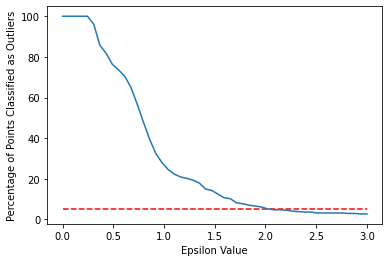

In [69]:
sns.lineplot(x=np.linspace(0.001,3,50),y=outlier_percent)
plt.ylabel("Percentage of Points Classified as Outliers")
plt.xlabel("Epsilon Value")
plt.hlines(y=5,xmin=0,xmax=3,colors='red',ls='--');

 Оптимальным вариантом может быть выбрано значение eps=2.

In [70]:
dbscan = DBSCAN(eps=2, min_samples=2*scaled_X.shape[1])
dbscan.fit(scaled_X)

DBSCAN(eps=2, min_samples=16)

## Cluster Analysis

In [71]:
df['Cluster'] = dbscan.labels_

**Взаимосвязь между годовыми расходами на молочные продукты (Milk) и продукты питания (Grocery) в зависимости от кластера**

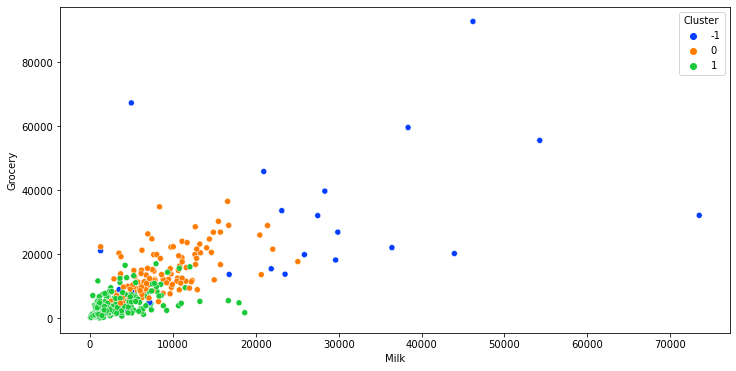

In [72]:
plt.figure(figsize=(12,6))
sns.scatterplot(y=df['Grocery'], x=df['Milk'], hue=df['Cluster'], palette='bright');

Высокоразмерные выбросы (справа вверху):  
- Явно выделяются по значению Milk и/или Grocery.  
- Это, вероятно, крупные закупки, не характерные для общей массы клиентов.  
- Они логично воспринимаются как выбросы.  

Близкие к центру облака выбросы:   
- Могут быть выбросами по другим признакам (например, Frozen, Fresh и т.д.).   
- Или у них просто низкая плотность соседей, несмотря на близость к другим точкам.  
- Такие выбросы — пограничные случаи, и при других параметрах DBSCAN могли бы быть отнесены к кластерам.  

Выбросы (кластер -1) не всегда "сильно удалены".
Хотя многие синие точки действительно лежат дальше основного облака данных, часть из них находится довольно близко к оранжевым и зелёным точкам. Это может визуально не выглядеть как выбросы, но они всё равно помечены как -1.  

**Взаимосвязь между годовыми расходами на молочные продукты (Milk) и расходами за год на моющие средства и бумажные изделия (Detergents Paper) в зависимости от кластера.**

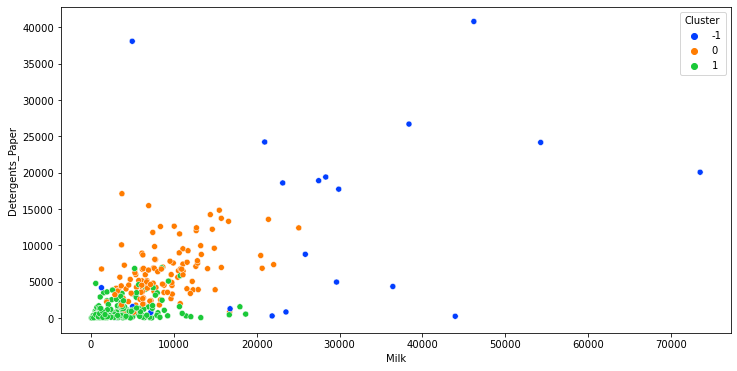

In [73]:
plt.figure(figsize=(12,6))
sns.scatterplot(y=df['Detergents_Paper'], x=df['Milk'], hue=df['Cluster'], palette='bright');

**Сравнение средних расходов по кластерам для каждой товарной категории.**

In [74]:
cats = df.drop(['Channel','Region'],axis=1)
cat_means = cats.groupby('Cluster').mean().round(2)
cat_means

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Cluster,,,,,,
-1,27729.92,22966.96,26609.60,11289.64,11173.56,6707.16
0,8227.67,8615.85,13859.67,1447.76,5969.58,1498.46
1,12326.97,3023.56,3655.33,3086.18,763.78,1083.79


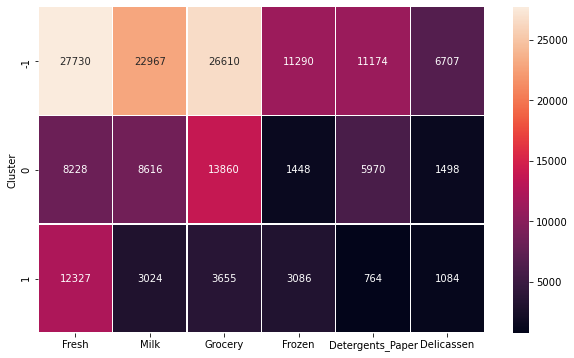

In [75]:
plt.figure(figsize=(10, 6))
sns.heatmap(cat_means, annot=True, linewidths = .4, fmt=".0f");

Кластер -1 можно интерпретировать как группу аномальных клиентов с высокими объёмами закупок, которые не подходят под общую модель:  
- Затраты существенно выше по всем категориям.  
- Особенно большие значения в Fresh, Milk, Grocery (более 20,000+).  
- Вероятно, это крупные клиенты (например, рестораны, отели, крупные закупщики).  
- Они не вписываются в общие паттерны и потому выделены как выбросы.  
  
Остальные кластеры 0 и 1 можно рассматривать как основные сегменты потребителей — средние и малые соответственно.  

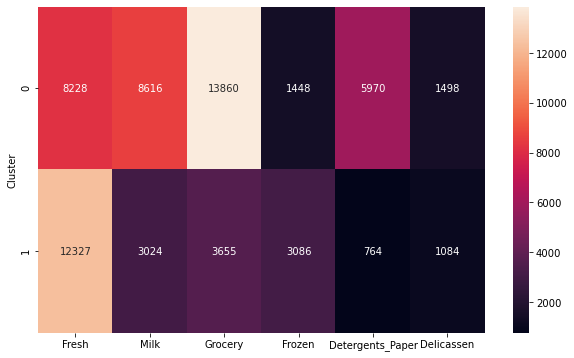

In [76]:
plt.figure(figsize=(10, 6))
sns.heatmap(cat_means.loc[[0,1]],annot=True, fmt=".0f");

Кластер 0:  
- Тратят в среднем больше в категориях Milk, Grosety и Detergents Paper.  
- Затраты в остальных категориях значительно ниже.  
- Может представлять средний по объёму покупательский сегмент (напр., небольшой магазин).  
  
Кластер 1:  
- Тратят в среднем больше в категориях Fresh и Frozen.   
- Наименьшие значения почти по всем категориям. Особенно низкие — в Detergents Paper (764) и Delicassen (1084).  
- Вероятно, это малые потребители, возможно, индивидуальные клиенты или мелкие предприниматели.  

**Анализ кластеров на основе нормализованных средних значений**

Нормализация данных позволит провести более объективное сравнение поведения кластеров, независимо от масштабов исходных значений.

In [80]:
scaler = MinMaxScaler()
data = scaler.fit_transform(cat_means)
scaled_means = pd.DataFrame(data,cat_means.index,cat_means.columns)
scaled_means

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Cluster,,,,,,
-1,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000
0,0.000000,0.280408,0.444551,0.000000,0.500087,0.07374
1,0.210196,0.000000,0.000000,0.166474,0.000000,0.00000


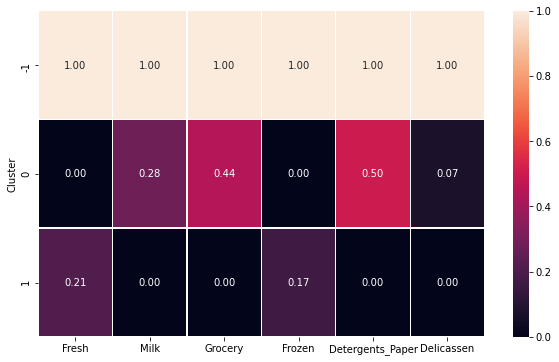

In [81]:
plt.figure(figsize=(10, 6))
sns.heatmap(scaled_means, linewidths = .4, annot=True, fmt=".2f");

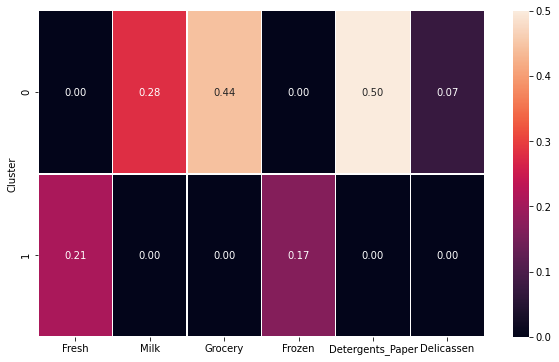

In [82]:
plt.figure(figsize=(10, 6))
sns.heatmap(scaled_means.loc[[0,1]],linewidths = .4, annot=True, fmt=".2f");

Кластер 0:  
- Наиболее выраженные признаки:   
    - Grocery: 0.44  
    - Detergents Paper: 0.50  
    - Milk: 0.28  
- Остальные признаки практически отсутствуют (значения около 0).  
- Интерпретация: данный кластер включает клиентов, ориентированных на закупку товаров повседневного спроса. Возможно, это розничные магазины или торговые точки, закупающие бакалею, бытовую химию и молочные продукты.  

Кластер 1:  
- Наиболее выраженные признаки:  
    - Fresh: 0.21  
    - Frozen: 0.17  
- Остальные признаки близки к нулю.  
- Интерпретация: в этом кластере сосредоточены клиенты, закупающие преимущественно свежие и замороженные продукты. Это могут быть небольшие кафе, рестораны или продуктовые лавки, ориентированные на свежие ингредиенты.  

В результате анализа можно выделить два чётко различающихся потребительских сегмента:  

- Кластер 0 — фокус на Grocery, Detergents Paper, Milk.
- Кластер 1 — акцент на Fresh и Frozen продукты.

Эти сегменты могут быть использованы для таргетированных маркетинговых стратегий, настройки ассортимента или оптимизации логистики.  